In [1]:
import os
last_update = '2020-04-30'
print(f'[Dataset list] (as of %s)'%last_update)
file_paths_raw = []
for dirname, _, filenames in os.walk('coronavirusdataset'):
    for filename in filenames:
        file_paths_raw.append(os.path.join(dirname, filename))
file_names = ['TimeAge.csv', 'TimeProvince.csv', 'Region.csv', 'TimeGender.csv'
              , 'Time.csv', 'Case.csv', 'Weather.csv', 'PatientInfo.csv'
              , 'PatientRoute.csv', 'SeoulFloating.csv', 'SearchTrend.csv', 'Policy.csv']
file_paths = [ j for i in file_names for j in file_paths_raw if i in j ]
file_paths

[Dataset list] (as of 2020-04-30)


['coronavirusdataset/TimeAge.csv',
 'coronavirusdataset/TimeProvince.csv',
 'coronavirusdataset/Region.csv',
 'coronavirusdataset/TimeGender.csv',
 'coronavirusdataset/Time.csv',
 'coronavirusdataset/Case.csv',
 'coronavirusdataset/Weather.csv',
 'coronavirusdataset/PatientInfo.csv',
 'coronavirusdataset/PatientRoute.csv',
 'coronavirusdataset/SeoulFloating.csv',
 'coronavirusdataset/SearchTrend.csv',
 'coronavirusdataset/Policy.csv']

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from dateutil.relativedelta import relativedelta
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
#packages used in SIR model
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import theano
import arviz as az



In [3]:
age_raw = pd.read_csv(file_paths[0])
print('[Sample data]')
age_raw.tail(3)

[Sample data]


date  time  age  confirmed  deceased
537  2020-04-30     0  60s       1348        35
538  2020-04-30     0  70s        709        74
539  2020-04-30     0  80s        485       118

In [4]:
age_list = age_raw.age.unique()
age_list

array(['0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s'],
      dtype=object)

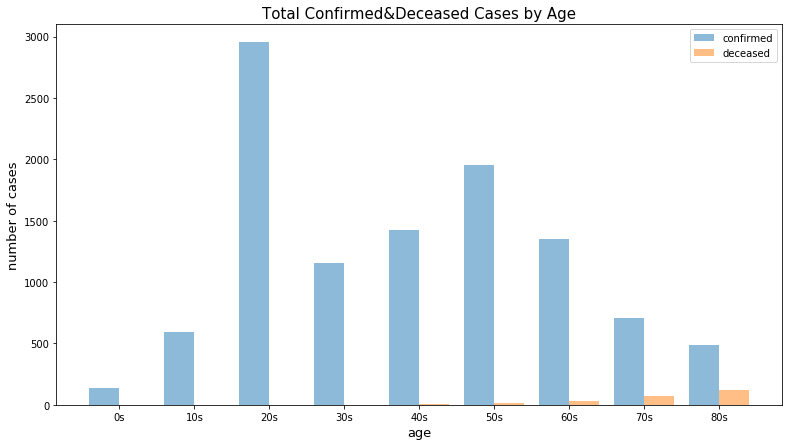

In [5]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Total Confirmed&Deceased Cases by Age', fontsize=15)
# sns.barplot(age_list, age_raw['confirmed'][-9:],label='confirmed')
# sns.barplot(age_list,age_raw['deceased'][-9:])
bar_width = 0.4
x=np.arange(len(age_list))
tick_label = age_list
plt.bar(x, age_raw['confirmed'][-9:], bar_width, align="center", label="confirmed", alpha=0.5)
plt.bar(x+bar_width, age_raw['deceased'][-9:], bar_width, align="center", \
        label="deceased", alpha=0.5)
ax.set_xlabel('age', size=13)
ax.set_ylabel('number of cases', size=13)
plt.xticks(x+bar_width/2, tick_label)
plt.legend()


In [6]:
pop_order = pd.DataFrame()
pop_order['age'] = age_list
pop_order['population'] = (4055740, 4732100, 6971785, 7203550, 8291728, 8587047, 6472987, 3591533, 1874109) #this data comes from KOSIS - Korean Statistical Information Service
pop_order['proportion'] = round(pop_order['population']/sum(pop_order['population']) * 100, 2)
pop_order = pop_order.sort_values('population', ascending=False)
pop_order.set_index(np.arange(1, 10), inplace=True)
pop_order

age  population  proportion
1  50s     8587047       16.58
2  40s     8291728       16.01
3  30s     7203550       13.91
4  20s     6971785       13.46
5  60s     6472987       12.50
6  10s     4732100        9.14
7   0s     4055740        7.83
8  70s     3591533        6.94
9  80s     1874109        3.62

In [7]:
confirmed_by_population = pop_order.sort_values('age')
confirmed_by_population['confirmed'] = list(age_raw[-9:].confirmed)
# get confirmed ratio regarding population
confirmed_by_population['confirmed_ratio'] = confirmed_by_population['confirmed']/confirmed_by_population['population'] * 100;
confirmed_by_population

age  population  proportion  confirmed  confirmed_ratio
7   0s     4055740        7.83        140         0.003452
6  10s     4732100        9.14        590         0.012468
4  20s     6971785       13.46       2952         0.042342
3  30s     7203550       13.91       1158         0.016075
2  40s     8291728       16.01       1427         0.017210
1  50s     8587047       16.58       1956         0.022778
5  60s     6472987       12.50       1348         0.020825
8  70s     3591533        6.94        709         0.019741
9  80s     1874109        3.62        485         0.025879

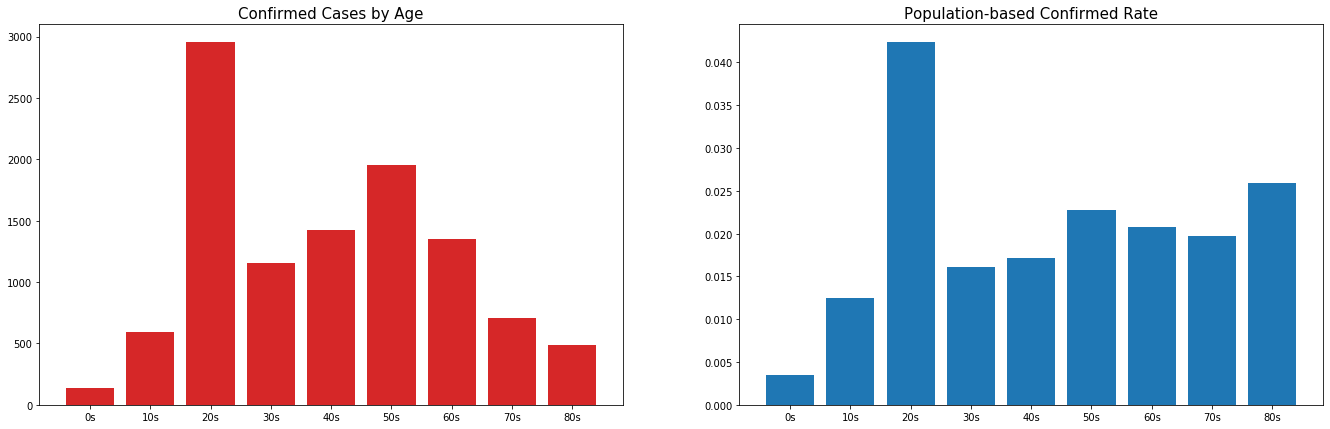

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 7))
color_list=['tab:red','tab:orange','tab:pink','tab:olive','c','tab:blue','tab:brown','tab:gray','tab:purple']
axes[0].set_title('Confirmed Cases by Age', fontsize=15)
axes[0].bar(age_list, confirmed_by_population.confirmed,color='tab:red')

axes[1].set_title('Population-based Confirmed Rate', fontsize=15)
axes[1].bar(age_list, confirmed_by_population.confirmed_ratio,color='tab:blue')

plt.show()

In [9]:
patient_route = pd.read_csv(file_paths[8])

In [10]:
# confirmed patient in map
import folium
default_location = [36.00,126.50]

#set map format
patient_map = folium.Map(location=default_location, 
                         zoom_start=6.5,
                         tiles='Stamen Toner')

#plot map spots
for latitude, longtitude,city in zip(patient_route['latitude'], 
           
                                     patient_route['longitude'],
                                     patient_route['city']):
    folium.CircleMarker([latitude, longtitude],
                        radius=3,
                        color='red',
                        popup =('City: ' + str(city) + '<br>'),
                        fill_color='pink',
                        fill_opacity=0.5 ).add_to(patient_map)
patient_map

In [11]:
patient_info=pd.read_csv(file_paths[7])

In [12]:
raw_cause= pd.read_csv(file_paths[5])
raw_cause.head(3)

case_id province           city  group         infection_case  confirmed  \
0  1000001    Seoul        Guro-gu   True    Guro-gu Call Center         98   
1  1000002    Seoul  Dongdaemun-gu   True          Dongan Church         20   
2  1000003    Seoul        Guro-gu   True  Manmin Central Church         41   

    latitude   longitude  
0  37.508163  126.884387  
1  37.592888  127.056766  
2  37.481059  126.894343

In [13]:
cause=raw_cause['confirmed'].groupby(raw_cause['infection_case']).sum()
cause=pd.DataFrame(cause)
cause=cause.reset_index() 
cause = cause.sort_values('confirmed', ascending=False)
cause.head(10)

infection_case  confirmed
31               Shincheonji Church       5212
38             contact with patient       1250
39                              etc       1030
42                  overseas inflow        777
28            Second Mi-Ju Hospital        196
11              Guro-gu Call Center        166
17  Hansarang Convalescent Hospital        128
3          Cheongdo Daenam Hospital        123
40          gym facility in Cheonan        103
4      Daesil Convalescent Hospital        100

In [14]:
#put cases other than top 6 into 'others'
cause.loc[len(cause), :] = cause[cause.confirmed<cause.confirmed.iloc[5]].sum()
cause_with_others = cause[cause.confirmed >= cause.confirmed.iloc[5]]
cause_with_others[6:]['infection_case']='other'
cause_with_others

/Users/jianangong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


infection_case  confirmed
31     Shincheonji Church     5212.0
38   contact with patient     1250.0
39                    etc     1030.0
42        overseas inflow      777.0
28  Second Mi-Ju Hospital      196.0
11    Guro-gu Call Center      166.0
43                  other     1218.0

In [16]:
time_df=pd.read_csv(file_paths[4])

time_df

date  time    test  negative  confirmed  released  deceased
0    2020-01-20    16       1         0          1         0         0
1    2020-01-21    16       1         0          1         0         0
2    2020-01-22    16       4         3          1         0         0
3    2020-01-23    16      22        21          1         0         0
4    2020-01-24    16      27        25          2         0         0
5    2020-01-25    16      27        25          2         0         0
6    2020-01-26    16      51        47          3         0         0
7    2020-01-27    16      61        56          4         0         0
8    2020-01-28    16     116        97          4         0         0
9    2020-01-29    16     187       155          4         0         0
10   2020-01-30    16     246       199          6         0         0
11   2020-01-31    16     312       245         11         0         0
12   2020-02-01    16     371       289         12         0         0
13   2020-02-02    16     429       327         15         0         0
14   2020-02-03    16     490       414         15         0         0
15   2020-02-04    16     607       462         16         0         0
16   2020-02-05    16     714       522         18         1         0
17   2020-02-06    16     885       693         23         2         0
18   2020-02-07    16    1352      1001         24         2         0
19   2020-02-08    16    2097      1134         24         2         0
20   2020-02-09    16    2598      1683         27         3         0
21   2020-02-10    16    3110      2552         27         4         0
22   2020-02-11    16    4325      3535         28         4         0
23   2020-02-12    16    5624      4811         28         7         0
24   2020-02-13    16    6511      5921         28         7         0
25   2020-02-14    16    7242      6679         28         7         0
26   2020-02-15    16    7734      7148         28         9         0
27   2020-02-16    16    8161      7647         29         9         0
28   2020-02-17    16    8718      7980         30        10         0
29   2020-02-18    16    9772      8923         31        12         0
..          ...   ...     ...       ...        ...       ...       ...
72   2020-04-01     0  421547    395075       9887      5567       165
73   2020-04-02     0  431743    403882       9976      5828       169
74   2020-04-03     0  443273    414303      10062      6021       174
75   2020-04-04     0  455032    424732      10156      6325       177
76   2020-04-05     0  461233    431425      10237      6463       183
77   2020-04-06     0  466804    437225      10284      6598       186
78   2020-04-07     0  477304    446323      10331      6694       192
79   2020-04-08     0  486003    457761      10384      6776       200
80   2020-04-09     0  494711    468779      10423      6973       204
81   2020-04-10     0  503051    477303      10450      7117       208
82   2020-04-11     0  510479    485929      10480      7243       211
83   2020-04-12     0  514621    490321      10512      7368       214
84   2020-04-13     0  518743    494815      10537      7447       217
85   2020-04-14     0  527438    502223      10564      7534       222
86   2020-04-15     0  534552    508935      10591      7616       225
87   2020-04-16     0  538775    513894      10613      7757       229
88   2020-04-17     0  546463    521642      10635      7829       230
89   2020-04-18     0  554834    530631      10653      7937       232
90   2020-04-19     0  559109    536205      10661      8042       234
91   2020-04-20     0  563035    540380      10674      8114       236
92   2020-04-21     0  571014    547610      10683      8213       237
93   2020-04-22     0  577959    555144      10694      8277       238
94   2020-04-23     0  583971    563130      10702      8411       240
95   2020-04-24     0  589520    569212      10708      8501       240
96   2020-04-25     0  595161    57

In [17]:
drop = ["time","test","negative"]
df_time=time_df.drop(drop,axis=1,inplace=False)
df_time.head()

date  confirmed  released  deceased
0  2020-01-20          1         0         0
1  2020-01-21          1         0         0
2  2020-01-22          1         0         0
3  2020-01-23          1         0         0
4  2020-01-24          2         0         0

In [18]:
df_time['recovered'] = df_time.released + df_time.deceased
drop_cols = ['released', 'deceased']
df_time_comb = df_time.drop(drop_cols, axis=1)
df_time_comb.index = df_time_comb['date']
df_time_comb.index = df_time_comb.index.map(
    lambda x: datetime.strptime(x, '%Y-%m-%d').replace(second=0))
df_time_comb=df_time_comb.drop(['date'],axis=1)
df_time_comb

confirmed  recovered
date                            
2020-01-20          1          0
2020-01-21          1          0
2020-01-22          1          0
2020-01-23          1          0
2020-01-24          2          0
2020-01-25          2          0
2020-01-26          3          0
2020-01-27          4          0
2020-01-28          4          0
2020-01-29          4          0
2020-01-30          6          0
2020-01-31         11          0
2020-02-01         12          0
2020-02-02         15          0
2020-02-03         15          0
2020-02-04         16          0
2020-02-05         18          1
2020-02-06         23          2
2020-02-07         24          2
2020-02-08         24          2
2020-02-09         27          3
2020-02-10         27          4
2020-02-11         28          4
2020-02-12         28          7
2020-02-13         28          7
2020-02-14         28          7
2020-02-15         28          9
2020-02-16         29          9
2020-02-17         30         10
2020-02-18         31         12
...               ...        ...
2020-04-01       9887       5732
2020-04-02       9976       5997
2020-04-03      10062       6195
2020-04-04      10156       6502
2020-04-05      10237       6646
2020-04-06      10284       6784
2020-04-07      10331       6886
2020-04-08      10384       6976
2020-04-09      10423       7177
2020-04-10      10450       7325
2020-04-11      10480       7454
2020-04-12      10512       7582
2020-04-13      10537       7664
2020-04-14      10564       7756
2020-04-15      10591       7841
2020-04-16      10613       7986
2020-04-17      10635       8059
2020-04-18      10653       8169
2020-04-19      10661       8276
2020-04-20      10674       8350
2020-04-21      10683       8450
2020-04-22      10694       8515
2020-04-23      10702       8651
2020-04-24      10708       8741
2020-04-25      10718       8875
2020-04-26      10728       8959
2020-04-27      10738       9007
2020-04-28      10752       9098
2020-04-29      10761       9168
2020-04-30      10765       9306

[102 rows x 2 columns]

/Users/jianangong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


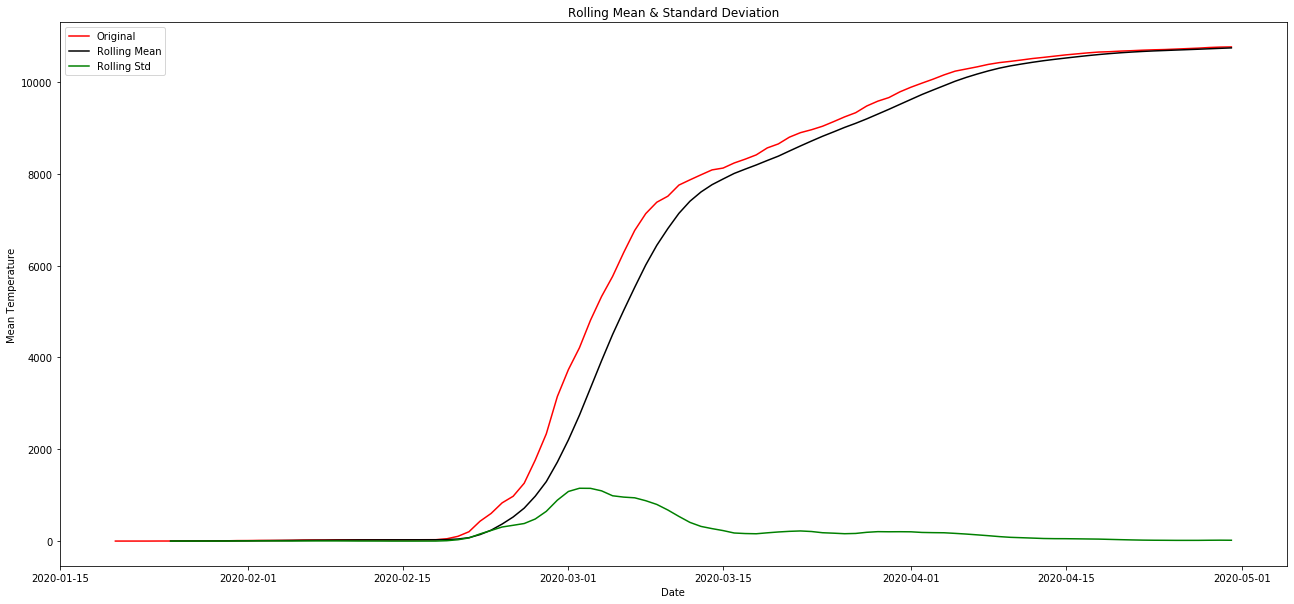

Test statistic:  -1.0028395922451598
p-value:  0.7522272166907489
Critical Values: {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}


In [19]:
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(6).mean()
    rolstd = ts.rolling(6).std()
    
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std)and adfuller test
check_mean_std(df_time_comb.confirmed)
check_adfuller(df_time_comb.confirmed)

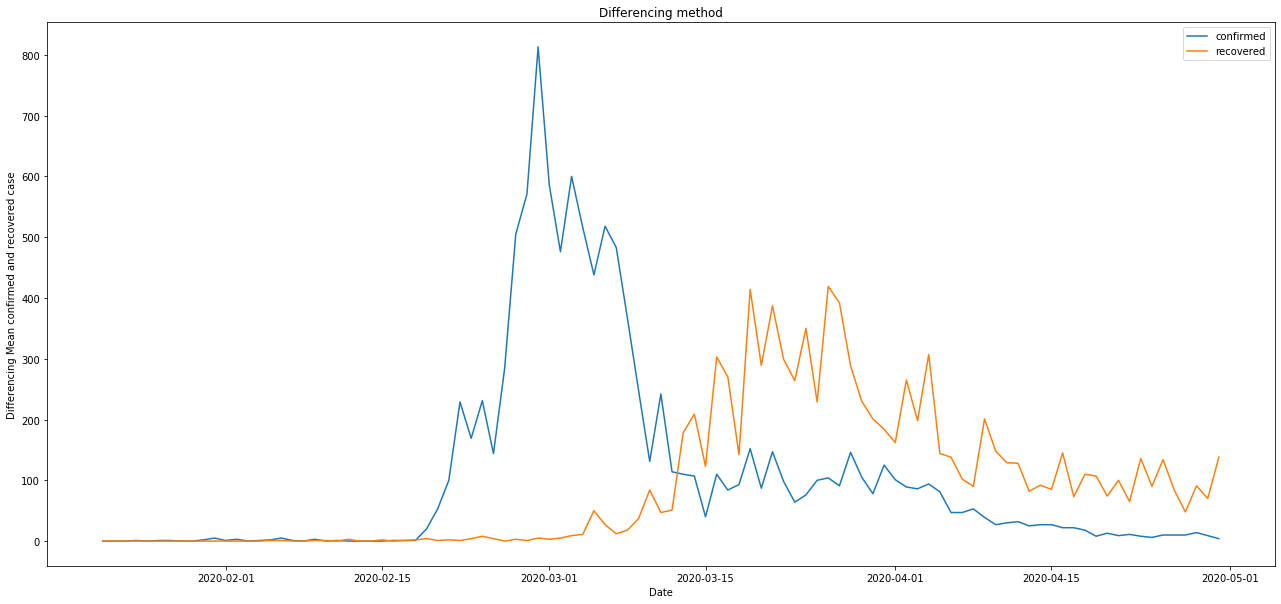

In [20]:
ts_diff = df_time_comb - df_time_comb.shift()
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Mean confirmed and recovered case")
plt.legend(["confirmed","recovered"])
plt.show()

/Users/jianangong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


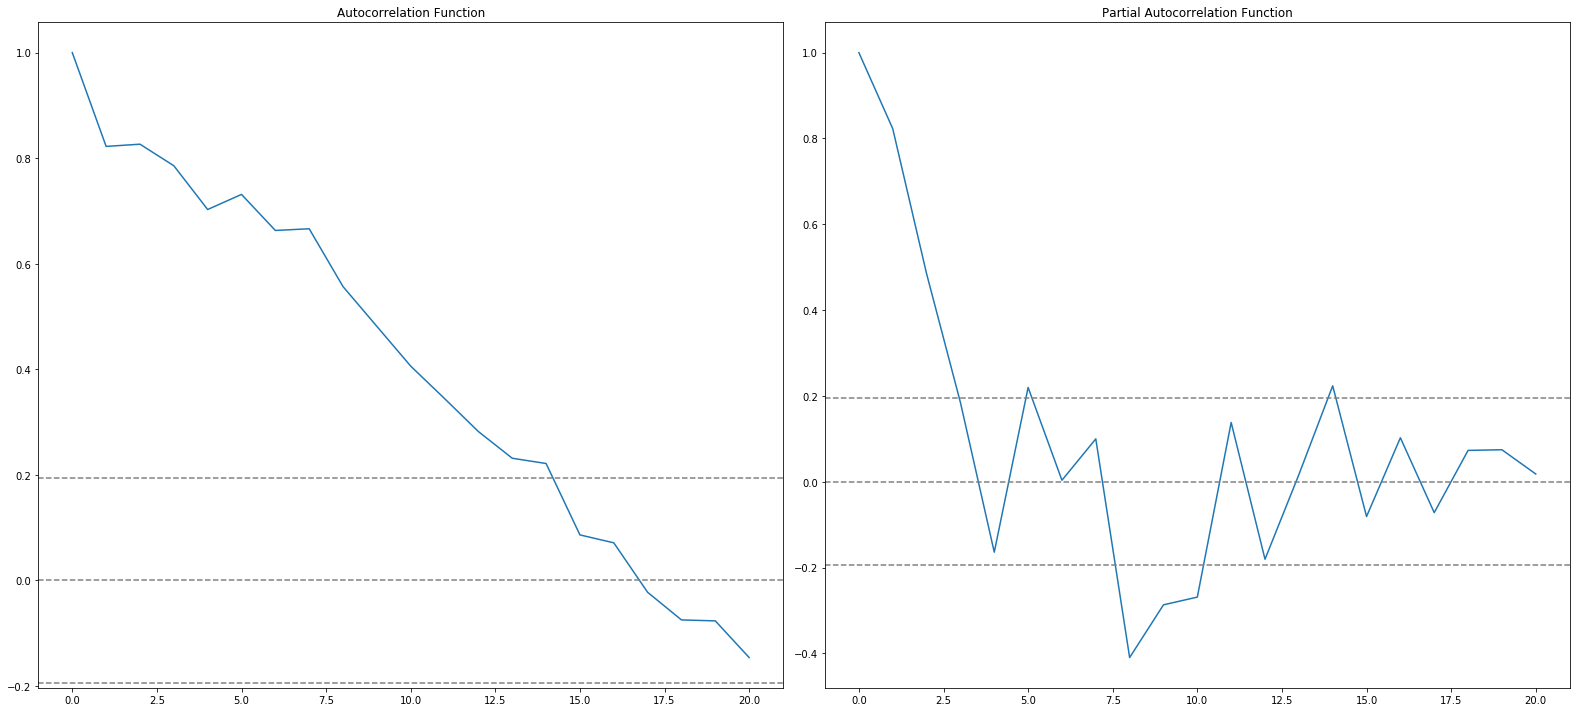

In [21]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff.recovered[20:], nlags=20)
lag_pacf = pacf(ts_diff.recovered[20:], nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [22]:
ts_diff

confirmed  recovered
date                            
2020-01-20        NaN        NaN
2020-01-21        0.0        0.0
2020-01-22        0.0        0.0
2020-01-23        0.0        0.0
2020-01-24        1.0        0.0
2020-01-25        0.0        0.0
2020-01-26        1.0        0.0
2020-01-27        1.0        0.0
2020-01-28        0.0        0.0
2020-01-29        0.0        0.0
2020-01-30        2.0        0.0
2020-01-31        5.0        0.0
2020-02-01        1.0        0.0
2020-02-02        3.0        0.0
2020-02-03        0.0        0.0
2020-02-04        1.0        0.0
2020-02-05        2.0        1.0
2020-02-06        5.0        1.0
2020-02-07        1.0        0.0
2020-02-08        0.0        0.0
2020-02-09        3.0        1.0
2020-02-10        0.0        1.0
2020-02-11        1.0        0.0
2020-02-12        0.0        3.0
2020-02-13        0.0        0.0
2020-02-14        0.0        0.0
2020-02-15        0.0        2.0
2020-02-16        1.0        0.0
2020-02-17        1.0        1.0
2020-02-18        1.0        2.0
...               ...        ...
2020-04-01      101.0      162.0
2020-04-02       89.0      265.0
2020-04-03       86.0      198.0
2020-04-04       94.0      307.0
2020-04-05       81.0      144.0
2020-04-06       47.0      138.0
2020-04-07       47.0      102.0
2020-04-08       53.0       90.0
2020-04-09       39.0      201.0
2020-04-10       27.0      148.0
2020-04-11       30.0      129.0
2020-04-12       32.0      128.0
2020-04-13       25.0       82.0
2020-04-14       27.0       92.0
2020-04-15       27.0       85.0
2020-04-16       22.0      145.0
2020-04-17       22.0       73.0
2020-04-18       18.0      110.0
2020-04-19        8.0      107.0
2020-04-20       13.0       74.0
2020-04-21        9.0      100.0
2020-04-22       11.0       65.0
2020-04-23        8.0      136.0
2020-04-24        6.0       90.0
2020-04-25       10.0      134.0
2020-04-26       10.0       84.0
2020-04-27       10.0       48.0
2020-04-28       14.0       91.0
2020-04-29        9.0       70.0
2020-04-30        4.0      138.0

[102 rows x 2 columns]

/Users/jianangong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


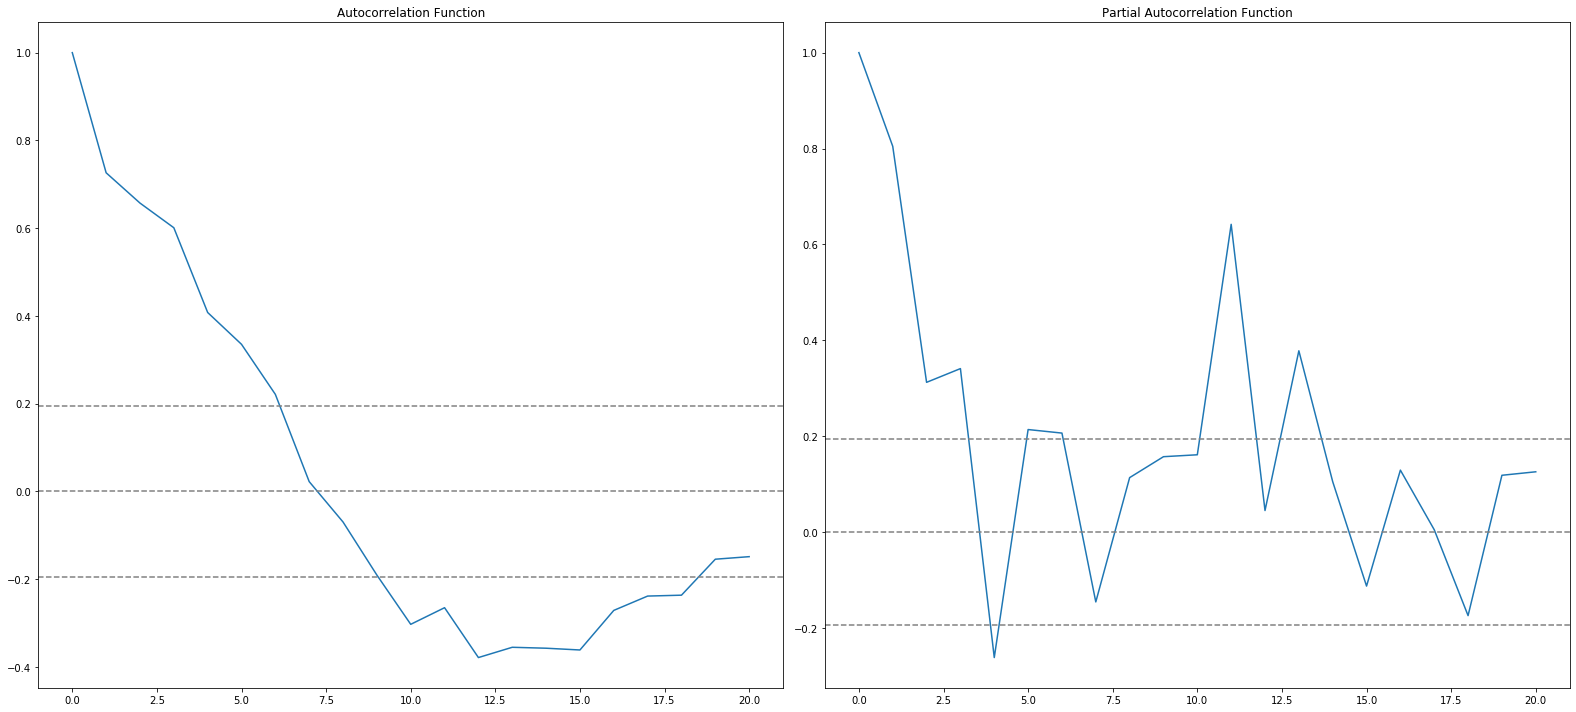

In [23]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff.confirmed[80:], nlags=20)
lag_pacf = pacf(ts_diff.confirmed[80:], nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/jianangong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


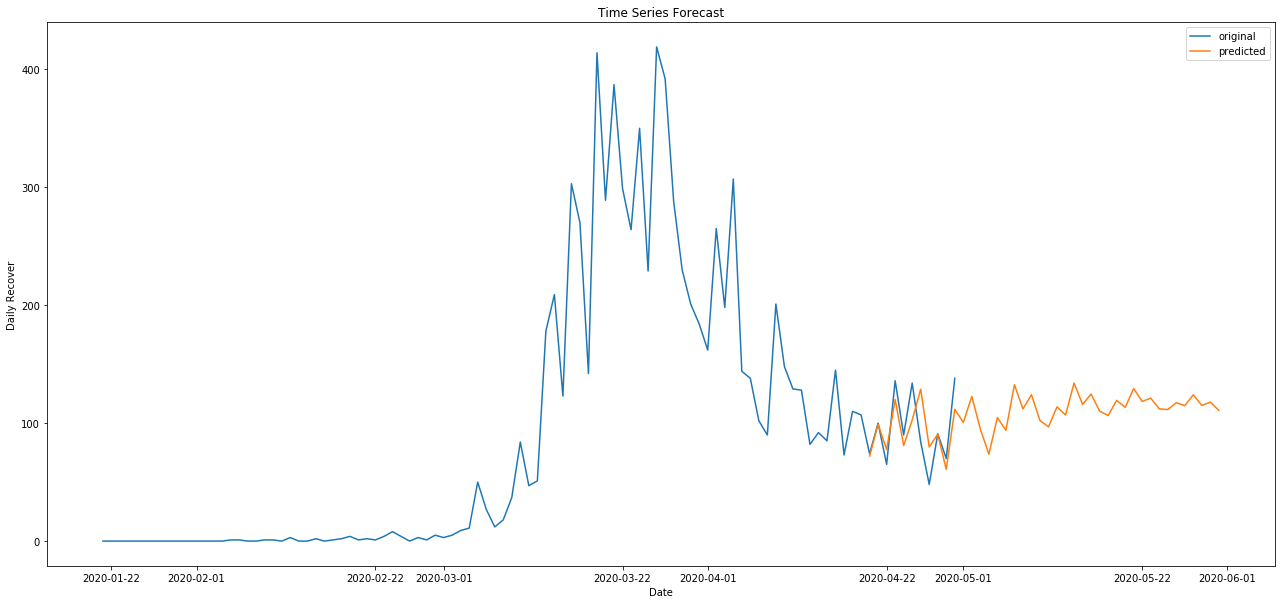

In [24]:
# fit model
model = ARIMA(ts_diff.recovered[20:], order=(12,0,2)) # (ARMA) = (1,0,1)
model_fit = model.fit(disp=0)

# predict
start_index = datetime(2020, 4, 20)
end_index = datetime(2020, 5, 31)
forecast_recover = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.plot(ts_diff.index,ts_diff.recovered,label = "original")
plt.plot(forecast_recover,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Daily Recover")
plt.legend()
plt.show()

/Users/jianangong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


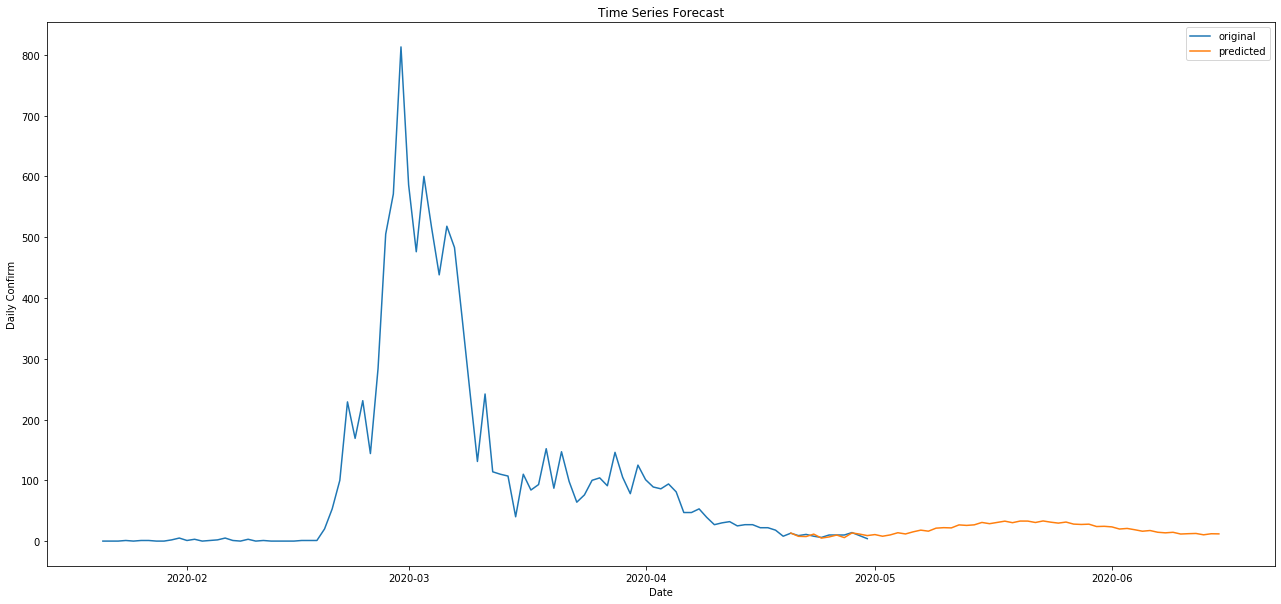

In [25]:
model = ARIMA(ts_diff.confirmed[80:], order=(7,0,3)) # (ARMA) = (1,0,1)
model_fit = model.fit(disp=0)

# predict
start_index = datetime(2020, 4, 20)
end_index = datetime(2020, 6, 15)
forecast_confirm = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.plot(ts_diff.index,ts_diff.confirmed,label = "original")
plt.plot(forecast_confirm,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Daily Confirm")
plt.legend()
plt.show()

In [34]:
DATA1=pd.DataFrame({'confirm':forecast_confirm[11:],'recover':forecast_recover[11:]})

In [35]:
forecast_recover[11:31].sum()+9306

11508.939226932158

In [36]:
DATA1['sum_confirm']=DATA1['confirm'].cumsum()+10765
DATA1['sum_recover']=DATA1['recover'].cumsum()+9306

In [37]:
DATA1[12:]

confirm     recover   sum_confirm   sum_recover
2020-05-13  25.805064  106.879051  10986.378184  10685.105086
2020-05-14  26.737430  133.961570  11013.115614  10819.066655
2020-05-15  30.671126  115.901459  11043.786740  10934.968114
2020-05-16  28.625066  124.656092  11072.411806  11059.624206
2020-05-17  30.708044  110.187927  11103.119850  11169.812133
2020-05-18  32.807300  106.434057  11135.927151  11276.246190
2020-05-19  30.278610  119.335642  11166.205761  11395.581832
2020-05-20  32.947591  113.357395  11199.153352  11508.939227
2020-05-21  32.902478  129.359335  11232.055830  11638.298562
2020-05-22  30.591825  118.390296  11262.647655  11756.688857
2020-05-23  33.139631  121.203927  11295.787286  11877.892785
2020-05-24  31.129306  112.151594  11326.916592  11990.044379
2020-05-25  29.569324  111.514445  11356.485916  12101.558823
2020-05-26  31.312413  117.338175  11387.798329  12218.896998
2020-05-27  27.941124  114.817272  11415.739454  12333.714270
2020-05-28  27.372897  124.019154  11443.112351  12457.733424
2020-05-29  27.840431  115.015538  11470.952782  12572.748962
2020-05-30  23.957251  117.865472  11494.910034  12690.614434
2020-05-31  24.314195  110.679501  11519.224229  12801.293935
2020-06-01  23.363531         NaN  11542.587760           NaN
2020-06-02  19.849210         NaN  11562.436971           NaN
2020-06-03  20.819570         NaN  11583.256540           NaN
2020-06-04  18.666657         NaN  11601.923197           NaN
2020-06-05  16.231023         NaN  11618.154220           NaN
2020-06-06  17.379864         NaN  11635.534085           NaN
2020-06-07  14.536164         NaN  11650.070249           NaN
2020-06-08  13.575782         NaN  11663.646031           NaN
2020-06-09  14.485206         NaN  11678.131237           NaN
2020-06-10  11.623101         NaN  11689.754339           NaN
2020-06-11  12.165702         NaN  11701.920040           NaN
2020-06-12  12.554170         NaN  11714.474210           NaN
2020-06-13  10.337649         NaN  11724.811860           NaN
2020-06-14  12.077821         NaN  11736.889681           NaN
2020-06-15  11.868091         NaN  11748.757772           NaN

In [38]:
forecast_recover[31:32]

2020-05-21    129.359335
Freq: D, dtype: float64

In [39]:
extend_2_months = [x + relativedelta(days=20) for x in df_time_comb.index]

#mirror and reverse confirmend data
data_confirmed_mirror = df_time_comb.confirmed.tolist()
data_confirmed_mirror.reverse()

#define delta from data,recover gap between recent 2 days
delta_extrapolant = 9306 - 9168

#extend recoverd
data_recovered_extrapolate = [9306 + delta_extrapolant + i*delta_extrapolant for i in range(0, len(extend_2_months))]

# extend data
data_extension = pd.DataFrame(list(zip(data_confirmed_mirror, data_recovered_extrapolate)), 
                                      index = extend_2_months, columns =['confirmed', 'recovered'])
#concat
data_extension_concat = pd.concat([df_time_comb, data_extension])
data_extension_concat = data_extension_concat[::9]  #to make it short

y_extension_concat =data_extension_concat.to_numpy()

In [40]:
y_extension_concat


array([[    1,     0],
       [    4,     0],
       [   24,     2],
       [   29,     9],
       [  977,    36],
       [ 5766,   123],
       [ 8086,   786],
       [ 8961,  3277],
       [ 9887,  5732],
       [10450,  7325],
       [10661,  8276],
       [10752,  9098],
       [10708, 10272],
       [10591, 11514],
       [10284, 12756],
       [ 9478, 13998],
       [ 8565, 15240],
       [ 7513, 16482],
       [ 3736, 17724],
       [  204, 18966],
       [   28, 20208],
       [   15, 21450],
       [    2, 22692]])

In [41]:
data_extension_concat_normal =data_extension_concat.div(23000)
y_extension_concat_normal=data_extension_concat_normal.to_numpy()
yobs = y_extension_concat_normal
yobs[0,0]=0.001
yobs[1,0]=0.001
yobs[0,1]=0.001
yobs[1,1]=0.001
yobs[2,1]=0.001
yobs[3,1]=0.001
yobs[3,1]=0.001
yobs[22,0]=0.001
yobs[21,0]=0.001
yobs

array([[0.001     , 0.001     ],
       [0.001     , 0.001     ],
       [0.00104348, 0.001     ],
       [0.00126087, 0.001     ],
       [0.04247826, 0.00156522],
       [0.25069565, 0.00534783],
       [0.35156522, 0.03417391],
       [0.3896087 , 0.14247826],
       [0.42986957, 0.24921739],
       [0.45434783, 0.31847826],
       [0.46352174, 0.35982609],
       [0.46747826, 0.39556522],
       [0.46556522, 0.4466087 ],
       [0.46047826, 0.5006087 ],
       [0.44713043, 0.5546087 ],
       [0.41208696, 0.6086087 ],
       [0.3723913 , 0.6626087 ],
       [0.32665217, 0.7166087 ],
       [0.16243478, 0.7706087 ],
       [0.00886957, 0.8246087 ],
       [0.00121739, 0.8786087 ],
       [0.001     , 0.9326087 ],
       [0.001     , 0.9866087 ]])

In [42]:
len(yobs)

23

In [43]:
def SIR(y, t, p):
    di = p[0] * (1. - y[0] - y[1] - p[1]/p[0]) * y[0]
    dr = p[1] * y[0]
    return [di, dr]

sir_model = DifferentialEquation(
    func = SIR,
    times = np.arange(0.25, 6, 0.25),
    n_states = 2,
    n_theta = 2,
    t0 = 0,
)

In [44]:
len(np.arange(0.25, 6, 0.25))

23

In [706]:
with pm.Model() as model1:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    gama = pm.Lognormal('gama', pm.math.log(2), 2)
    beta = pm.Deterministic('beta', gama*R0)

    sir_curves = sir_model(y0=[0.01, 0.0], theta=[beta, gama])

    # data likelihood
    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace1 = pm.sample(1000, tune=500, target_accept=0.8, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gama, R0, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [10:36<00:00,  2.29it/s]


In [708]:
with model1:
    posterior_predictive1 = pm.sample_posterior_predictive(trace1)
    
with model1:
    res1 = az.from_pymc3(trace=trace1, prior=prior, posterior_predictive=posterior_predictive1)

100%|██████████| 2000/2000 [01:20<00:00, 24.72it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c6cb948d0>,
      dtype=object)

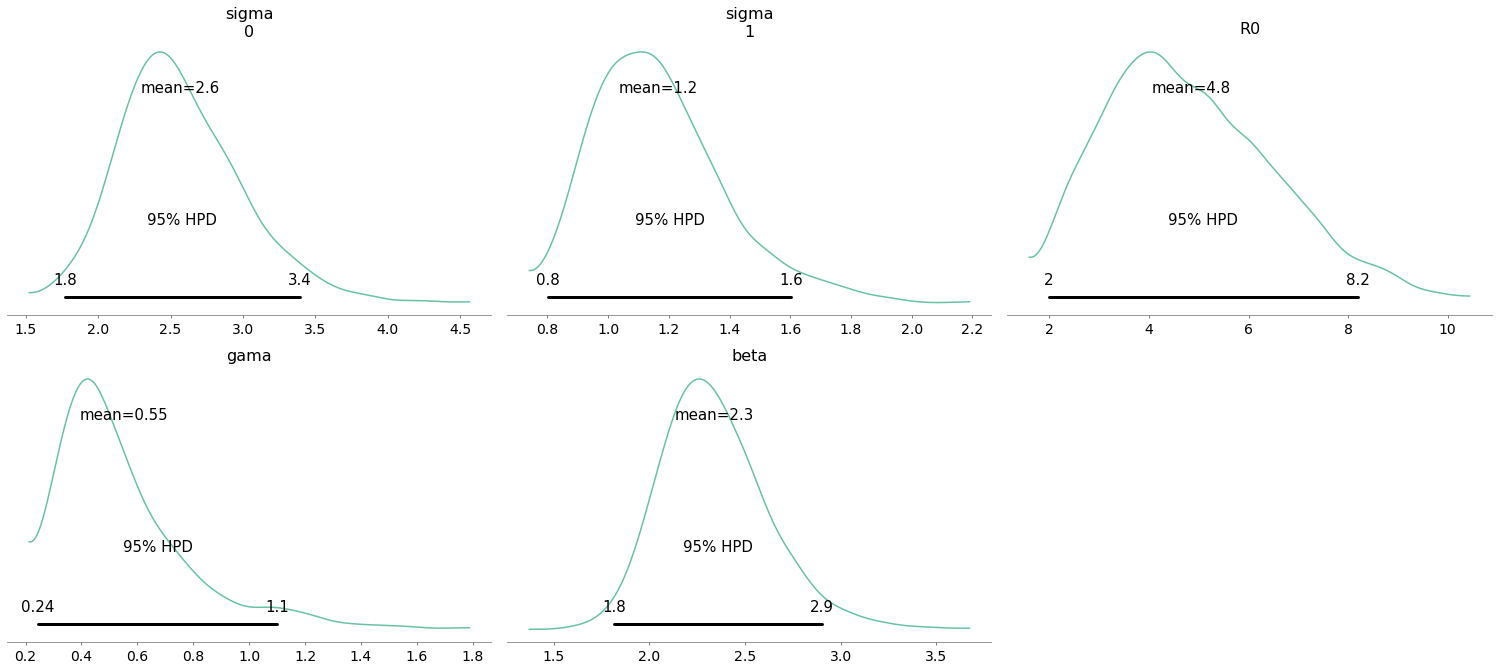

In [709]:
az.plot_posterior(res1, round_to=2, credible_interval=0.95)